In [58]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline

# machine learning
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from imblearn.pipeline import Pipeline

#preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Metrics Libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



In [59]:
dfRaw = pd.read_csv('./Data/Input.csv', delimiter = ',', nrows = 100000)


# Encode categorical columns
df = dfRaw.copy()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Convert everything to float
df = df.astype(float)


dfRaw.head(5)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [60]:
#Checking for balance in target
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=df['isFraud'].value_counts())])
fig.show()

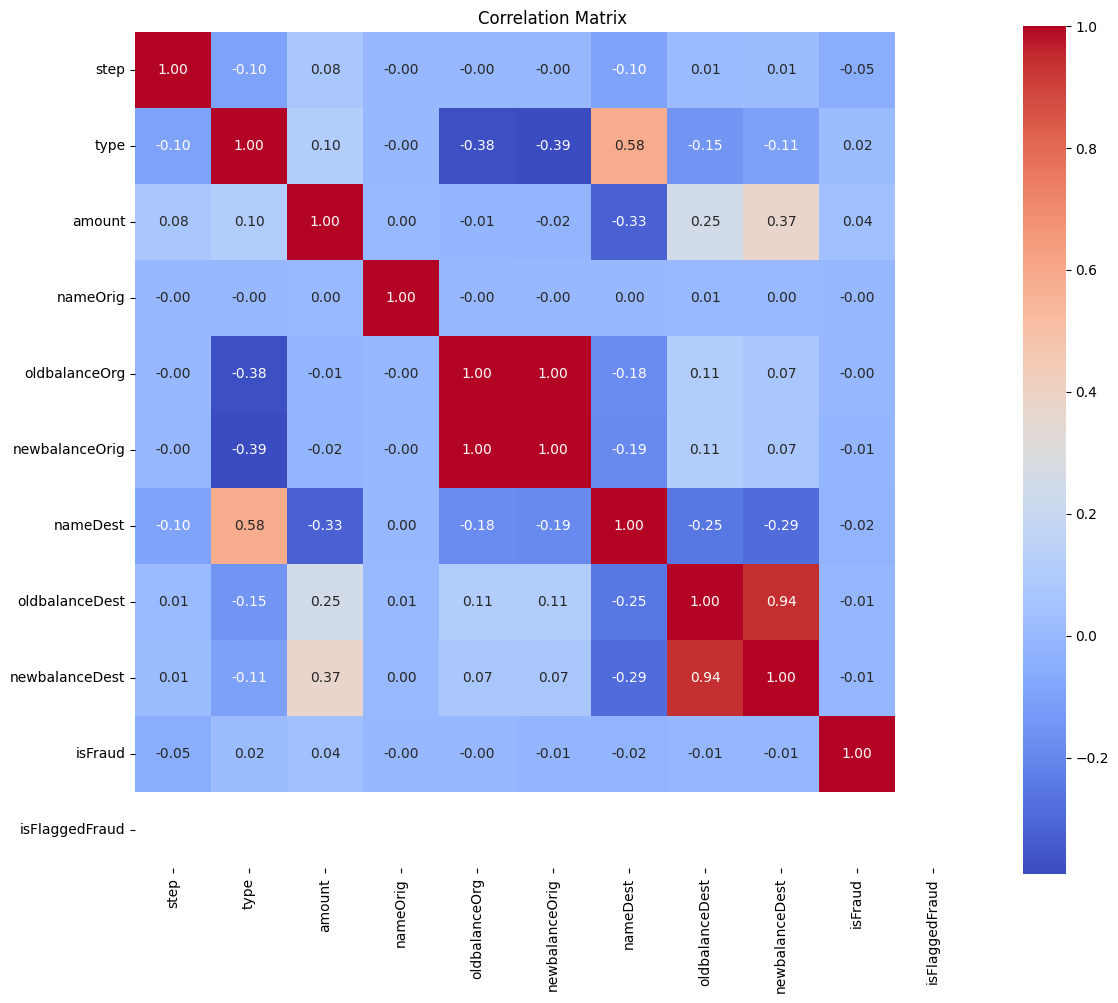

isFraud           1.000000
amount            0.036422
type              0.015555
nameOrig         -0.003244
oldbalanceOrg    -0.004144
newbalanceDest   -0.006394
oldbalanceDest   -0.009266
newbalanceOrig   -0.010872
nameDest         -0.022002
step             -0.051329
isFlaggedFraud         NaN
Name: isFraud, dtype: float64


In [61]:
plt.figure(figsize=(12, 10))

# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

target_corr = corr_matrix['isFraud'].sort_values(ascending=False)
print(target_corr)

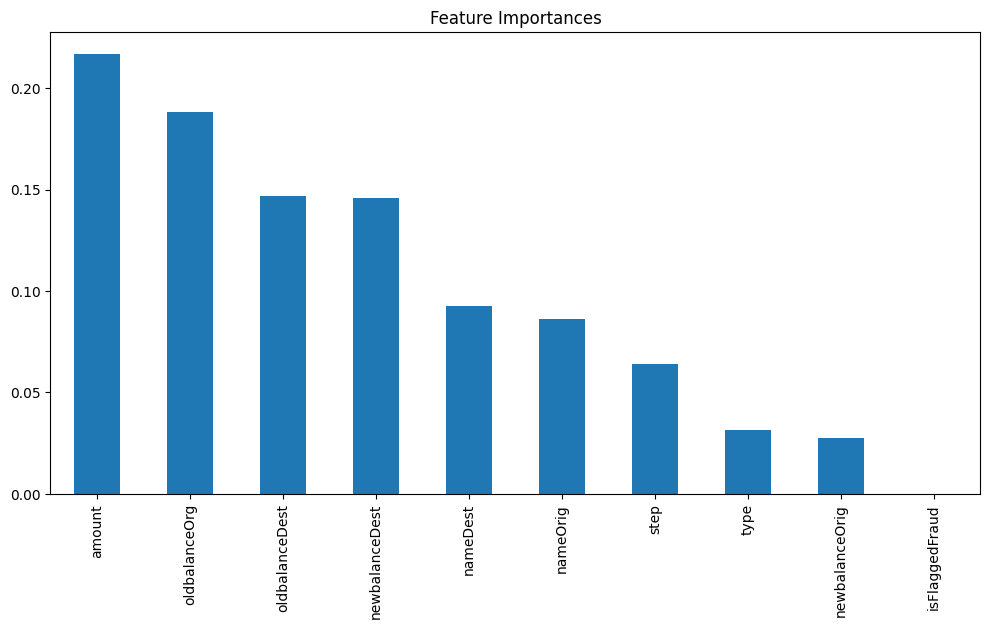

In [62]:
#preprocessing

#drop 'isFraud' from X
X = df.drop('isFraud', axis=1)
y = df['isFraud']

#split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)

#determine the importance of each feature
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title='Feature Importances')
plt.show()

In [63]:
#dropping the least important features and feature engineering (maybe Ill remove the type and newbalance columns later)

df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']


In [64]:
# Scaling for unsupervised learning

X_scaled = df.drop(columns=['isFraud'])

def Standard_Scaler(df):
    scaler = StandardScaler()
    
    # Fit on data and transform
    df[col_names] = scaler.fit_transform(df[col_names])
    
    return df

col_names = ['type', 'amount', 'step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
X_scaled = Standard_Scaler(X_scaled)

X_scaled.head(5)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,-4.108186,0.844868,-0.475641,11862.0,-0.264702,-0.270632,31981.0,-0.366533,-0.422519,0.0,9839.64,0.0
1,-4.108186,0.844868,-0.498805,34345.0,-0.320397,-0.322604,33288.0,-0.366533,-0.422519,0.0,1864.28,0.0
2,-4.108186,1.583505,-0.503694,15636.0,-0.328278,-0.329753,9303.0,-0.366533,-0.422519,0.0,181.00,0.0
3,-4.108186,-0.632406,-0.503694,91777.0,-0.328278,-0.329753,8273.0,-0.357715,-0.422519,0.0,181.00,-21182.0
4,-4.108186,0.844868,-0.470330,54041.0,-0.312802,-0.318731,16681.0,-0.366533,-0.422519,0.0,11668.14,0.0


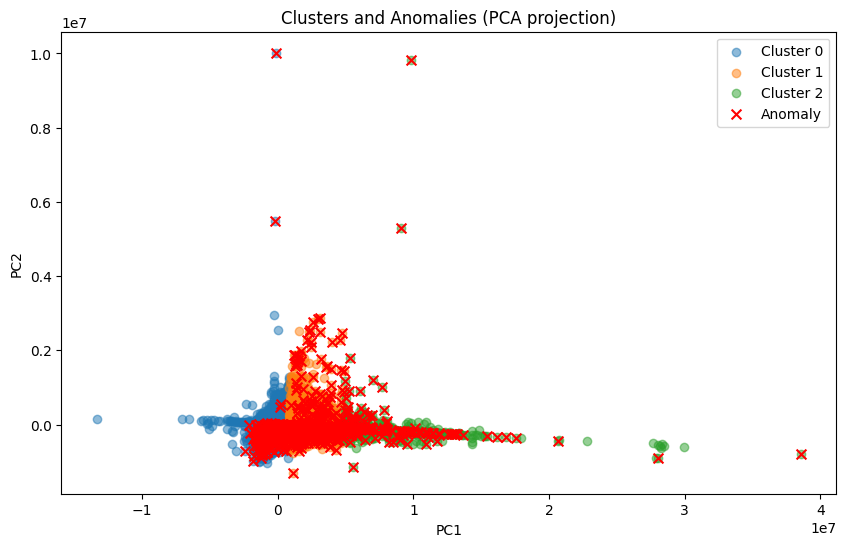

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest,anomaly,cluster,PC1,PC2
4440,4.0,4.0,10000000.00,85204.0,12930418.44,2930418.44,11720.0,0.0,0.00,1.0,0.0,10000000.00,0.00,1,0,-9.397740e+04,1.001896e+07
4441,4.0,1.0,10000000.00,66326.0,10000000.00,0.00,10592.0,0.0,9941904.21,1.0,0.0,10000000.00,9941904.21,1,2,9.845707e+06,9.811570e+06
10395,7.0,4.0,5460002.91,82648.0,5460002.91,0.00,4508.0,0.0,0.00,1.0,0.0,5460002.91,0.00,1,0,-1.889026e+05,5.480480e+06
10396,7.0,1.0,5460002.91,30301.0,5460002.91,0.00,3567.0,0.0,9281535.44,1.0,0.0,5460002.91,9281535.44,1,2,9.090560e+06,5.286849e+06
4443,4.0,1.0,2930418.44,53838.0,2930418.44,0.00,11638.0,3616012.1,6963508.84,1.0,0.0,2930418.44,3347496.74,1,1,3.104920e+06,2.882094e+06


In [65]:
# Unsupervised Learning with KMEans and Isolation Forest
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

iso = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = (iso.fit_predict(X_scaled) == -1).astype(int)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df['cluster'] = clusters

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Use cluster color and anomaly shape
plt.figure(figsize=(10, 6))
for cluster_id in sorted(df['cluster'].unique()):
    cluster_mask = df['cluster'] == cluster_id
    plt.scatter(
        X_pca[cluster_mask, 0],
        X_pca[cluster_mask, 1],
        label=f'Cluster {cluster_id}',
        alpha=0.5
    )

# Overlay anomalies (red X markers)
anomalies = df['anomaly'] == 1
plt.scatter(
    X_pca[anomalies, 0],
    X_pca[anomalies, 1],
    color='red', marker='x', label='Anomaly', s=50
)

plt.title("Clusters and Anomalies (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

df_show = df.copy()

df_show.groupby('cluster').mean(numeric_only=True)

df_show['PC1'] = X_pca[:, 0]
df_show['PC2'] = X_pca[:, 1]

df_show['anomaly'] = iso.fit_predict(X_scaled)
df_show['anomaly'] = df_show['anomaly'].map({1: 0, -1: 1})

df_show[df_show['anomaly'] == 1].sort_values(by='PC2', ascending=False).head(5)

In [66]:
# Making sets for supervised learning, using the feature importances and the new cluster column

X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)

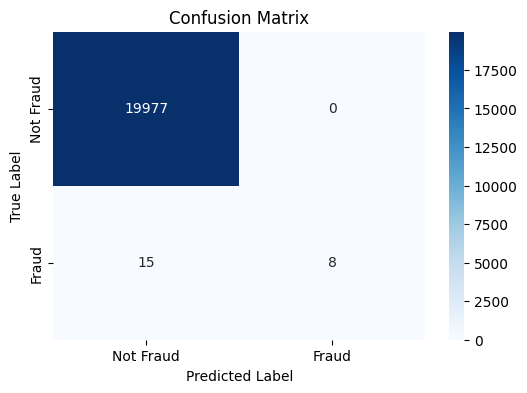

Random Forest Classifier Accuracy: [0.99925   0.9991875 0.999125  0.9990625 0.9991875]
Cross Validation Recall scores are: [0.33333333 0.27777778 0.26315789 0.26315789 0.36842105]
Average Cross Validation Recall score: 0.30116959064327486
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     19977
       Fraud       1.00      0.35      0.52        23

    accuracy                           1.00     20000
   macro avg       1.00      0.67      0.76     20000
weighted avg       1.00      1.00      1.00     20000



In [67]:
#training without sampling

kf = StratifiedKFold(n_splits=5, shuffle=False)

rf = RandomForestClassifier(n_estimators=100, random_state=13)

rf.fit(X_train, y_train)
Y_pred = rf.predict(X_test)
#rf.score(X_train, y_train)

scoreAcc = cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')
scoreRe = cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')

cm = confusion_matrix(y_test, Y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Random Forest Classifier Accuracy: {}".format(scoreAcc))
print("Cross Validation Recall scores are: {}".format(scoreRe))
print("Average Cross Validation Recall score: {}".format(scoreRe.mean()))
print(classification_report(y_test, Y_pred, target_names=["Not Fraud", "Fraud"]))

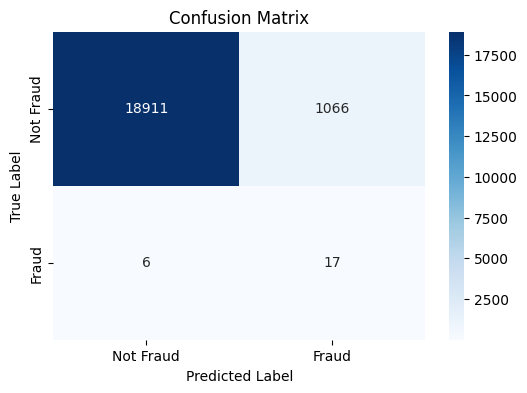

Random Forest Classifier Accuracy: [0.95025   0.9500625 0.95      0.960625  0.9555   ]
Cross Validation Recall scores are: [0.77777778 0.61111111 0.73684211 0.68421053 0.94736842]
Average Cross Validation Recall score: 0.7514619883040935
              precision    recall  f1-score   support

   Not Fraud       1.00      0.95      0.97     19977
       Fraud       0.02      0.74      0.03        23

    accuracy                           0.95     20000
   macro avg       0.51      0.84      0.50     20000
weighted avg       1.00      0.95      0.97     20000



In [68]:
#training with SMOTE (with optimal parameters)

from imblearn.over_sampling import SMOTE

kf = StratifiedKFold(n_splits=5, shuffle=False)

pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=13)),
    ('rf', RandomForestClassifier(
        n_estimators=1000,
        random_state=13,
        max_depth=10,
        class_weight={0: 1, 1: 7}
    ))
])
#the weights should be around 1:6-1:7
#rf = RandomForestClassifier(n_estimators=1000, random_state=13, max_depth=10, class_weight={0: 1, 1: 6})
#rf.fit(X_train_resampled, y_train_resampled)

pipeline.fit(X_train, y_train)
Y_pred = pipeline.predict(X_test)
#rf.score(X_train, y_train)

scoreAcc = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='accuracy')
scoreRe = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='recall')

cm = confusion_matrix(y_test, Y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Random Forest Classifier Accuracy: {}".format(scoreAcc))
print("Cross Validation Recall scores are: {}".format(scoreRe))
print("Average Cross Validation Recall score: {}".format(scoreRe.mean()))
print(classification_report(y_test, Y_pred, target_names=["Not Fraud", "Fraud"]))

In [69]:
# Hyperparameter grid to optimize recall
'''
rf = RandomForestClassifier(random_state=13)

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'class_weight': ['balanced', {0: 1, 1: 10}]
}

grid_search = GridSearchCV(rf, param_grid, scoring='recall', cv=5, verbose=2)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters
print("Best parameters found:", grid_search.best_params_)
# Best parameters found: {'class_weight': {0: 1, 1: 10}, 'max_depth': 10, 'n_estimators': 500} n can be more
# Dont use this for now, it takes too long to run, so only run as one cell


best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

scoreAcc = cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')
scoreRe = cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')

cm = confusion_matrix(y_test, Y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Random Forest Classifier Accuracy: {}".format(scoreAcc))
print("Cross Validation Recall scores are: {}".format(scoreRe))
print("Average Cross Validation Recall score: {}".format(scoreRe.mean()))
print(classification_report(y_test, Y_pred, target_names=["Not Fraud", "Fraud"]))
'''

'\nrf = RandomForestClassifier(random_state=13)\n\nparam_grid = {\n    \'n_estimators\': [100, 200, 500],\n    \'max_depth\': [None, 10, 20],\n    \'class_weight\': [\'balanced\', {0: 1, 1: 10}]\n}\n\ngrid_search = GridSearchCV(rf, param_grid, scoring=\'recall\', cv=5, verbose=2)\ngrid_search.fit(X_train_resampled, y_train_resampled)\n\n# Best parameters\nprint("Best parameters found:", grid_search.best_params_)\n# Best parameters found: {\'class_weight\': {0: 1, 1: 10}, \'max_depth\': 10, \'n_estimators\': 500} n can be more\n# Dont use this for now, it takes too long to run, so only run as one cell\n\n\nbest_rf = grid_search.best_estimator_\ny_pred = best_rf.predict(X_test)\n\nscoreAcc = cross_val_score(rf, X_train, y_train, cv=kf, scoring=\'accuracy\')\nscoreRe = cross_val_score(rf, X_train, y_train, cv=kf, scoring=\'recall\')\n\ncm = confusion_matrix(y_test, Y_pred)\n\nplt.figure(figsize=(6, 4))\nsns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"],